In [1]:
import torch
import numpy as np
from tqdm import tqdm 
from time import sleep 
import matplotlib.pyplot as plt


from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
def plotting_losses(cnn, cnn_batch_norm):
    plt.plot(cnn.detach(), 'r', label="CNN")
    plt.plot(cnn_batch_norm.detach(), 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()
    
def acc_plot(cnn, cnn_batch_norm):
    plt.plot(cnn, 'r', label="CNN")
    plt.plot(cnn_batch_norm, 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()
    
def plot_images(images):
    for image in images:
        plt.figure()
        plt.imshow(image)
    

In [4]:
class Dataset:
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, mode: str):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.train_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.RandomHorizontalFlip(0.3), # FLips the image w.r.t horizontal axis
                                                   transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                                   transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                                   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                                   transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                        std=[0.5, 0.5, 0.5])]) #Normalize all the images
                                                  
 
 
        self.test_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                 ])
    def __len__(self):
        a = len(self.labels)
        return a
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.mode == "train":
            image = self.train_transform(image)
        elif self.mode == "test":
            image = self.test_transform(image)
        return image, label

In [5]:
dataset_x = datasets.CIFAR10(root = "cifar/", train = True, download = False)
dataset_y = datasets.CIFAR10(root = "cifar/", train = False, download = False)
train_dataset = Dataset(dataset_x.data, dataset_x.targets, "train")
test_dataset = Dataset(dataset_y.data, dataset_y.targets, "test")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


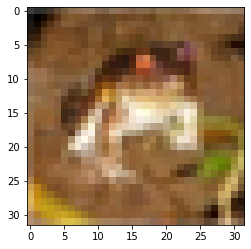

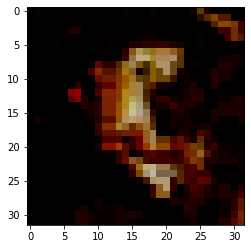

In [6]:
image_before = dataset_x[0][0]
image_after = train_dataset[0][0].transpose(0,2)
images = [image_before, image_after]
plot_images(images)

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, feature_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, feature_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(feature_channels, in_channels, kernel_size=3, padding=1)
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x += identity
        x = F.relu(x)
        return x 

In [25]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, in_channels, num_classes, layers_list):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.block1 = ResBlock(self.in_channels, 32)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.block2 = ResBlock(self.in_channels, 64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.block3 = ResBlock(self.in_channels, 128)
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        x = torch.randn(32,32,3).view(-1,3,32,32)
        
        self._to_linear = None 
        self.convs(x)
        self.fc = nn.Linear(self._to_linear, num_classes)
                

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = self.block1.forward(x)
        x = F.relu(self.conv2(x))
        x = self.block2.forward(x)
        x = F.relu(self.conv3(x))
        x = self.block3.forward(x)
        x = self.avg_pool(x)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [26]:
def train(model, optimizer, dataloader):
    for x,y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [27]:
def training(model_factory, dataloader, optimizer_factory, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
        print(f"Loss of Epoch {epoch} is {losses[epoch]}")
        print(f"Accuracy of Epoch {epoch} is {accuracies[epoch]}")
    return losses, accuracies

In [28]:
layer_features = [32, 64, 128]
model = ResNet(ResBlock, 3, 10, layer_features)
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))
losses, accuracies = training(model, train_loader, optimizer, 25) 

  4%|▍         | 1/25 [00:29<11:53, 29.73s/it]

Loss of Epoch 0 is 1.443000078201294
Accuracy of Epoch 0 is 0.5049999952316284


  8%|▊         | 2/25 [00:59<11:26, 29.84s/it]

Loss of Epoch 1 is 1.3865103721618652
Accuracy of Epoch 1 is 0.5446999669075012


 12%|█▏        | 3/25 [01:29<10:59, 29.96s/it]

Loss of Epoch 2 is 1.003507375717163
Accuracy of Epoch 2 is 0.6015999913215637


 16%|█▌        | 4/25 [01:59<10:28, 29.93s/it]

Loss of Epoch 3 is 1.0333675146102905
Accuracy of Epoch 3 is 0.6423999667167664


 20%|██        | 5/25 [02:29<09:55, 29.76s/it]

Loss of Epoch 4 is 0.8266948461532593
Accuracy of Epoch 4 is 0.6784999966621399


 24%|██▍       | 6/25 [02:58<09:22, 29.60s/it]

Loss of Epoch 5 is 0.9832304120063782
Accuracy of Epoch 5 is 0.6976000070571899


 28%|██▊       | 7/25 [03:28<08:53, 29.64s/it]

Loss of Epoch 6 is 0.7717235684394836
Accuracy of Epoch 6 is 0.7049999833106995


 32%|███▏      | 8/25 [03:57<08:24, 29.70s/it]

Loss of Epoch 7 is 0.641426682472229
Accuracy of Epoch 7 is 0.7300999760627747


 36%|███▌      | 9/25 [04:27<07:55, 29.73s/it]

Loss of Epoch 8 is 0.8411058187484741
Accuracy of Epoch 8 is 0.7394999861717224


 40%|████      | 10/25 [04:57<07:26, 29.75s/it]

Loss of Epoch 9 is 0.4576021134853363
Accuracy of Epoch 9 is 0.7414000034332275


 44%|████▍     | 11/25 [05:27<06:58, 29.87s/it]

Loss of Epoch 10 is 0.7417916655540466
Accuracy of Epoch 10 is 0.7554999589920044


 48%|████▊     | 12/25 [05:57<06:29, 29.94s/it]

Loss of Epoch 11 is 0.898195743560791
Accuracy of Epoch 11 is 0.7705999612808228


 52%|█████▏    | 13/25 [06:27<06:00, 30.02s/it]

Loss of Epoch 12 is 0.980333685874939
Accuracy of Epoch 12 is 0.7601000070571899


 56%|█████▌    | 14/25 [06:58<05:30, 30.06s/it]

Loss of Epoch 13 is 0.7171703577041626
Accuracy of Epoch 13 is 0.7833999991416931


 60%|██████    | 15/25 [07:27<04:58, 29.85s/it]

Loss of Epoch 14 is 0.7496456503868103
Accuracy of Epoch 14 is 0.7847999930381775


 64%|██████▍   | 16/25 [07:57<04:29, 29.94s/it]

Loss of Epoch 15 is 0.5177578926086426
Accuracy of Epoch 15 is 0.7949000000953674


 68%|██████▊   | 17/25 [08:27<03:59, 29.98s/it]

Loss of Epoch 16 is 0.5604304671287537
Accuracy of Epoch 16 is 0.7911999821662903


 72%|███████▏  | 18/25 [08:57<03:30, 30.05s/it]

Loss of Epoch 17 is 0.9513866305351257
Accuracy of Epoch 17 is 0.7931999564170837


 76%|███████▌  | 19/25 [09:28<03:00, 30.08s/it]

Loss of Epoch 18 is 0.653720498085022
Accuracy of Epoch 18 is 0.8044999837875366


 80%|████████  | 20/25 [09:58<02:30, 30.13s/it]

Loss of Epoch 19 is 0.580748438835144
Accuracy of Epoch 19 is 0.7949000000953674


 84%|████████▍ | 21/25 [10:28<02:00, 30.20s/it]

Loss of Epoch 20 is 0.5332086682319641
Accuracy of Epoch 20 is 0.8019999861717224


 88%|████████▊ | 22/25 [10:58<01:30, 30.17s/it]

Loss of Epoch 21 is 0.5926464200019836
Accuracy of Epoch 21 is 0.8111000061035156


 92%|█████████▏| 23/25 [11:28<01:00, 30.13s/it]

Loss of Epoch 22 is 0.6373921632766724
Accuracy of Epoch 22 is 0.8139999508857727


 96%|█████████▌| 24/25 [11:58<00:30, 30.14s/it]

Loss of Epoch 23 is 0.8479655981063843
Accuracy of Epoch 23 is 0.8033999800682068


100%|██████████| 25/25 [12:29<00:00, 29.98s/it]

Loss of Epoch 24 is 0.6083990335464478
Accuracy of Epoch 24 is 0.8123999834060669
